<a href="https://colab.research.google.com/github/thunder913/Deep-Learning/blob/main/stocks_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import kagglehub
import numpy as np
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import pickle
import sys
import pdb
import tensorflow as tf
import keras

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, AdditiveAttention, Multiply, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import Huber

# Stock Price Prediction usign LSTM

by Andon Gorchov (@thunderman913)

## Abstract

Stock market prediction is a very challenging task, due to the high volatility and nonlienear financial data. Many people try to "beat" the market, but it is a difficult task, even for the Wall Street traders. In this project, we develop a deep learning model based on Long Short-Term Memory(LSTM), in order to predict stock prices. This type of models should be well-suited for time-series forecasting as they effectively capture long-term dependencies and trends. The model will be trained on historical data with precalculated key technical indicators, as well as feature scaling, attention mechanism and different hyperparameters will be tried. Our goal is to create a model, that predicts the short-term stock price trends. The model will be only technical indicators, so in the future it can be extended with market sentiment analysis, economic factors and financial data.

## 1. Problem Definition

To predict the stock market is a very challenging century old task, that has not yet been perfected. If anyone can foresee the stock prices, he would for sure be very wealthy, since it is a very dynamic enviornment. The goal of the project is to create a good enough LSTM model, that predicts the stock price in the short-term. We will experiment with different hyperparameters and models. The data, that will be used is 24 million rows of stock data. We will feature engineer different technical indicators such as RSI, MACD and moving averages in order to predict the most correct price. I am not expecting the model to predict very accurately to the actual price, due to the volatility of the stock data, but I expect it to manage to follow the trend and give close to real values.

## 2. Data analysis and tidying

We will need a big stock dataset, in order for the model to predict different tickers accurately. We will be using tihs one:

https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

It contains daily stock price information for more than 7000 tickers. For our training purposes we will only use tickers with data, that has at least 100 days of information, which is around 7600 tickers and in total of 24 million rows of data, which are from 1998 to mid 2021 Apart from the given data, there will be some feature engineered variables, that we will look into.

In the project we will be using pickles, in order not to download the dataset every time. Also all the fitted models are going to be stored in pickles.

In [ ]:
# TODO do some distributions by price, before and after tidying

At first let's define path variables, depending on the running enviornment.

All the fitting of the models will be done on google colab, since it will be very time consuming to use my local machine. All the files will be saved to the google drive, when running on colab and locally, when run locally.

In [45]:
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    base_path = './drive/MyDrive/DL_Pickles/'
else:
    base_path = 'pickles'

path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

stock_prices_path = f"{path}/stocks_latest/stock_prices_latest.csv"

stock_data_path = f"{base_path}/stock_data_processed.pkl"
scaler_path = f"{base_path}/scalers.pkl"

data_path = f"{base_path}/scaled_stock_data.pkl"  # Path to store scaled DataFrame

sequence_length = 30

numerical_columns = [
    'close_adjusted', 'RSI', '5_day_MA', '10_day_MA',
    '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA',
    'MACD', 'Signal_Line'
]

Next up let's define some functions for the data processing. At first we will create methods for calculating Relative Strength Index (RSI) and MACD (Moving Average Convergence Divergence). The RSI is a momentum indicator used to measure the speed and change of price movements. Usually below 30 means oversold and above 70 means overbought. MACD is a trend following momentum indicator, that shows the relationship between two moving averages of a stock's price. In our case we will use the most common MACD with short window 12, long window 26 and signal window 9.

In [36]:
def calculate_rsi(ticker_data, period = 14):
    delta = ticker_data['close_adjusted'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / np.where(avg_loss != 0, avg_loss, 1)

    ticker_data['RSI'] = 100 - (100 / (1 + rs))

    return ticker_data

def calculate_macd(ticker_data, short_window=12, long_window=26, signal_window=9):
    # Calculate EMA short and long
    ema_short = ticker_data['close_adjusted'].ewm(span=short_window, adjust=False).mean()
    ema_long = ticker_data['close_adjusted'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD and Signal Line
    ticker_data['MACD'] = ema_short - ema_long
    ticker_data['Signal_Line'] = ticker_data['MACD'].ewm(span=signal_window, adjust=False).mean()

    return ticker_data

Next up let's define a method for adding the technical indicators to the main dataframe. Apart from calling the above methods, it also calculates moving averages (MA).

Moving averages are a trend following indicator, that smooths out price data to identify the direction of a trend. It helps traders filter out short term price fluctuations and focus on the broader trend.

In [44]:
def process_ticker_data(df):
    """
    Add historical price features for specific days ago for each stock (grouped by ticker).
    Also calculate the peak price and days since the peak price for each stock.
    """

    print('Calculated RSI')
    # Calculate RSI
    df = df.groupby('ticker', group_keys=False).apply(calculate_rsi)

    print('Calculated moving averages')
    # Add moving averages
    moving_average_windows = [5, 10, 20, 50, 100, 200]  # Specify moving average windows
    for window in moving_average_windows:
        df[f'{window}_day_MA'] = df.groupby('ticker')['close_adjusted'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)

    print('Calculated MACD')
    # Calculate MACD and Signal Line

    df = df.groupby('ticker', group_keys=False).apply(calculate_macd)

    # Remove the first 200 rows for each ticker
    df = df.groupby('ticker').apply(lambda group: group.iloc[200:]).reset_index(drop=True)

    return df

Next up let's create a method for scaling the stock data. We will be using a different minmaxscaler for each ticker, because otherwise the data gets really compressed and the models cannot accurately predict it. While some outliers with high/low data are alone by themselves.

In [46]:
#TODO show distribution if scaled together

In [14]:
def scale_stock_data(stock_data_tidy, numerical_columns):
    """
    Scales numerical columns for each stock ticker independently using MinMaxScaler.

    - Loads existing scalers and scaled data if available.
    - Trains and saves new scalers & scaled data if they don’t exist.
    - Returns a new scaled DataFrame without modifying the original.

    Args:
        stock_data_tidy: The input stock data.
        numerical_columns: The numerical column names, that need to be rescaled.

    Returns:
        pd.DataFrame: The scaled stock data.
    """

    if os.path.exists(scaler_path) and os.path.exists(data_path):
        print("Loading existing scalers and scaled data...")

        # Load scalers
        with open(scaler_path, "rb") as f:
            scalers = pickle.load(f)

        # Load scaled stock data
        with open(data_path, "rb") as f:
            new_data_tidy_rescaled = pickle.load(f)

        print("Loaded scalers and scaled data from file.")
        return new_data_tidy_rescaled

    # If files don't exist, compute scalers and scaled data
    print("Recalculating scalers and scaled data...")
    scalers = {} 
    new_data_tidy_rescaled = [] 

    for ticker in stock_data_tidy['ticker_encoded'].unique():
        print(f"Processing ticker: {ticker}")

        ticker_data = stock_data_tidy[stock_data_tidy['ticker_encoded'] == ticker].copy()

        scaler = MinMaxScaler()
        scalers[ticker] = scaler.fit(ticker_data[numerical_columns])

        ticker_data.loc[:, numerical_columns] = scaler.transform(ticker_data[numerical_columns])

        new_data_tidy_rescaled.append(ticker_data)

    new_data_tidy_rescaled = pd.concat(new_data_tidy_rescaled, ignore_index=True)

    with open(scaler_path, "wb") as f:
        pickle.dump(scalers, f)

    with open(data_path, "wb") as f:
        pickle.dump(new_data_tidy_rescaled, f)

    print("Saved scalers and scaled data to file.")

    return new_data_tidy_rescaled

Finally let's create the method for getting the tidied data. It contains all the technical indicators, scaled prices and tickers.

In [17]:
def getTidiedStockData():
    """
    Read and tidy the stock data dataset. If the processed stock data already exists as a pickle file,
    it loads and returns the data. Otherwise, it processes the raw stock data, cleans it, adds features,
    and saves the tidy data to a pickle file for future use.
    """

    # Check if the file exists
    if os.path.exists(stock_data_path):
        print('found pickle')
        return pd.read_pickle(stock_data_path)

    # Read the basic data and some tidying
    stock_data = pd.read_csv(stock_prices_path)
    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)
    stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close', 'volume'])

    # Encode labels
    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])

    stock_data_tidy['day_of_week'] = stock_data_tidy['date'].dt.dayofweek

    stock_data_tidy = scale_stock_data(stock_data_tidy, numerical_columns)

    stock_data_tidy.to_pickle(stock_data_path)

    return stock_data_tidy

In [48]:
stock_data_tidy = getTidiedStockData()

with open(scaler_path, "rb") as f:
    scalers = pickle.load(f)

found pickle


In [54]:
def plot_stock_chart(stock_data_tidy, ticker, start_date=None, end_date=None):
    """
    Plot a stock chart for a specific ticker.

    Parameters:
        stock_data_tidy (DataFrame): The DataFrame containing stock data.
        ticker (str): The ticker to plot.
        start_date (str): Optional start date (e.g., '2023-01-01').
        end_date (str): Optional end date (e.g., '2023-12-31').
    """
    # Filter data for the specific ticker and date range
    stock_data_tidy['date'] = pd.to_datetime(stock_data_tidy['date'])
    filtered_data = stock_data_tidy[stock_data_tidy['ticker'] == ticker]

    if start_date:
        filtered_data = filtered_data[filtered_data['date'] >= start_date]
    if end_date:
        filtered_data = filtered_data[filtered_data['date'] <= end_date]

    # Ensure data is sorted by date
    filtered_data = filtered_data.sort_values(by='date')

    # Plot the stock chart
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['date'], filtered_data['close_adjusted'], label='Close Price', color='blue', linewidth=2)

    # Add moving averages if they exist in the DataFrame
    for col in ['5_day_MA', '50_day_MA', '100_day_MA']:
        if col in filtered_data.columns:
            plt.plot(filtered_data['date'], filtered_data[col], label=col, linestyle='--')

    # Chart settings
    plt.title(f"Stock Chart for {ticker}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

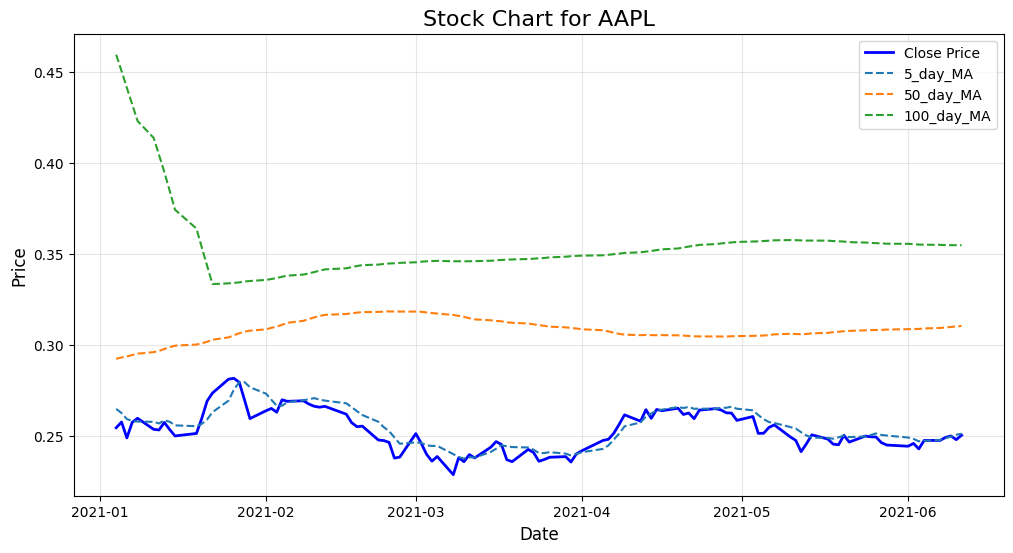

In [56]:
plot_stock_chart(stock_data_tidy, ticker='AAPL', start_date='2021-01-01', end_date='2022-12-31')

In [57]:
#TODO show some charts. Why are moving average higher than the price always?? it is fishy

## 3. Model Training

In [59]:
# TODO say something about the training

## 3.1. Data preparation for training

In [58]:
stock_data_tidy = stock_data_tidy.drop(columns=['price_1_days_ago', 'price_2_days_ago',
    'price_3_days_ago', 'price_4_days_ago', 'price_5_days_ago',
    'price_10_days_ago', 'price_15_days_ago', 'price_30_days_ago',
    'price_60_days_ago', 'price_90_days_ago'])

numerical_columns.extend(['day_of_week', 'ticker_encoded'])

In [15]:
# TODO if all works with scalers for every ticker, remove this

# numerical_columns = [
#     'close_adjusted', 'RSI', '5_day_MA', '10_day_MA',
#     '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA',
#     'MACD', 'Signal_Line'
# ]


# scaler = MinMaxScaler()

# stock_data_tidy[numerical_columns] = scaler.fit_transform(stock_data_tidy[numerical_columns])

# numerical_columns.extend(['day_of_week', 'ticker_encoded'])

In [53]:
def inverse_transform_predictions(y_pred, ticker):
    # Use the correct scaler for this ticker
    scaler = scalers[ticker]

    # Inverse transform only the first column (close_adjusted)
    y_pred_rescaled = scaler.inverse_transform(
        np.concatenate((np.array(y_pred).reshape(-1,1), np.zeros((len(y_pred), len(numerical_columns) - 3))), axis=1)
    )[:,0]

    return y_pred_rescaled

In [18]:
def preprocess_data(stock_data_tidy, numerical_columns, sequence_length):
    data = stock_data_tidy[numerical_columns].values

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i])
        y.append(data[i, 0])

    X = np.array(X)
    y = np.array(y)

    return X, y

In [23]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

processed_data_path = base_path + 'processed_data_full_2/'

def preprocess_grouped_data(stock_data_tidy, numerical_columns, target_column, sequence_length):
    tickers = stock_data_tidy["ticker_encoded"].unique()

    for ticker in tickers:
        ticker_data = stock_data_tidy[stock_data_tidy["ticker_encoded"] == ticker].sort_values(by="date")
        numerical_data = ticker_data[numerical_columns].values

        if(ticker % 1000 == 0):
          print('Processing ', ticker)
        if len(ticker_data) > sequence_length:
            x_ticker = sliding_window_view(numerical_data[:-1], window_shape=(sequence_length, len(numerical_columns)))
            x_ticker = x_ticker.reshape(-1, sequence_length, len(numerical_columns))

            y_ticker = ticker_data[target_column].values[sequence_length:]

            np.save(os.path.join(processed_data_path, f"x_ticker_{ticker}.npy"), x_ticker)
            np.save(os.path.join(processed_data_path, f"y_ticker_{ticker}.npy"), y_ticker)

## 3.2. Generator

In [24]:
stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'])

if os.path.exists(processed_data_path) and os.path.isdir(processed_data_path):
    has_file = any(os.path.isfile(os.path.join(processed_data_path, item)) for item in os.listdir(processed_data_path))
    if has_file:
        print("There are files in the processed_data_path.")
    else:
      print('Beginning to process the data...\n')
      preprocess_grouped_data(stock_data_tidy, numerical_columns, 'close_adjusted', sequence_length)
else:
    print("The processed_data_path does not exist or is not a directory.")

There are files in the processed_data_path.


In [25]:
def data_generator(tickers, processed_data_path, batch_size=32):
    """Generates batches dynamically for the given tickers."""
    while True:
        for ticker in tickers:
            # Load data for the current ticker
            x_path = os.path.join(processed_data_path, f"x_ticker_{ticker}.npy")
            y_path = os.path.join(processed_data_path, f"y_ticker_{ticker}.npy")

            # Ensure file exists
            if not os.path.exists(x_path) or not os.path.exists(y_path):
                print(f"Skipping {ticker}: Missing files.")
                continue

            x_data = np.load(x_path)
            y_data = np.load(y_path)

            # Ensure data is compatible with the batch size
            steps_per_epoch = len(x_data) // batch_size
            x_data = x_data[:steps_per_epoch * batch_size]
            y_data = y_data[:steps_per_epoch * batch_size]

            # Yield batches
            for i in range(steps_per_epoch):
                x_batch = x_data[i * batch_size: (i + 1) * batch_size]
                y_batch = y_data[i * batch_size: (i + 1) * batch_size]
                yield x_batch, y_batch


In [60]:
tickers = stock_data_tidy["ticker_encoded"].unique()
tickers.sort()
train_gen = data_generator(tickers, processed_data_path)
early_stopping = EarlyStopping(monitor="loss", patience=30, restore_best_weights=True)

NameError: name 'data_generator' is not defined

## 3.3. Model

In [19]:
def create_lstm_model(sequence_length, num_features, lstm_units_1=50, lstm_units_2=50, dropout_rate=0.1):
    """
    Optimized LSTM model for stock price prediction with Additive Attention.
    """
    numerical_input = Input(shape=(sequence_length, num_features), name="numerical_input")

    first_lstm_layer = LSTM(lstm_units_1, return_sequences=True, name="lstm_layer_1", dropout=dropout_rate)(numerical_input)
    normalized_1 = BatchNormalization()(first_lstm_layer)

    second_lstm_layer = LSTM(lstm_units_2, return_sequences=True, name="lstm_layer_2", dropout=dropout_rate)(normalized_1)
    normalized_2 = BatchNormalization()(second_lstm_layer)

    # Attention mechanism
    attention = AdditiveAttention(name="attention_layer")([normalized_2, normalized_2])
    attended = Multiply()([second_lstm_layer, attention])

    flat = Flatten()(attended)

    x = Dense(64, activation='relu', name="dense_1")(flat)

    output = Dense(32, activation='relu', name="dense_2")(x)

    output = Dense(1, activation='linear', name="output")(output)

    model = Model(inputs=numerical_input, outputs=output, name="Optimized_LSTM_Model_with_Attention")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [20]:
lstm_model = create_lstm_model(sequence_length=sequence_length, num_features=len(numerical_columns))

In [21]:
lstm_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ numerical_input           │ (None, 30, 12)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_1 (LSTM)       │ (None, 30, 50)         │         12,600 │ numerical_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 30, 50)         │            200 │ lstm_layer_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_2 (LSTM)       │ (None, 30, 50)         │         20,200 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 30, 50)         │            200 │ lstm_layer_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 30, 50)         │             50 │ batch_normalization_1… │
│ (AdditiveAttention)       │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 30, 50)         │              0 │ lstm_layer_2[0][0],    │
│                           │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1500)           │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │         96,064 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             33 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 131,427 (513.39 KB)

 Trainable params: 131,227 (512.61 KB)

 Non-trainable params: 200 (800.00 B)

## 3.4. Training and results

In [31]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath=base_path + 'lstm_model_epoch_{epoch:02d}.keras',  # Saves model for each epoch
    save_best_only=False,  # Save model at every epoch
    save_weights_only=False,  # Save full model (architecture + weights)
    verbose=1
)

# Train the model with checkpoint callback
# lstm_model.fit(
#     train_gen,
#     steps_per_epoch=40000,
#     epochs=200,
#     callbacks=[checkpoint, early_stopping],  # Include checkpoint callback
#     verbose=2
# )

print("Training complete!")


Training complete!


In [32]:
#lstm_model.save(base_path + 'lstm_model4_2.keras')

## 4. Conclusion

In [33]:
def get_sequences_and_predict(ticker, stock_data, numerical_columns, sequence_length, model):
    """
    Extracts sequences for a given ticker, performs predictions, and returns rescaled values.

    Parameters:
    - ticker: Stock ticker symbol.
    - stock_data: DataFrame containing stock data.
    - numerical_columns: List of numerical feature columns.
    - sequence_length: Length of sequences.
    - model: Trained model for prediction.

    Returns:
    - dates: Pandas Series of date values.
    - y_sequence_rescaled: Rescaled actual stock prices.
    - y_pred_rescaled: Rescaled predicted stock prices.
    """
    ticker_data = stock_data[stock_data.ticker == ticker]

    X = ticker_data[numerical_columns].values
    y = ticker_data['close_adjusted'].values

    X_sequences = []
    y_sequences = []

    for i in range(sequence_length, len(X)):
        X_sequences.append(X[i-sequence_length:i])
        y_sequences.append(y[i])

    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)

    y_pred = model.predict(X_sequences)

    y_sequence_rescaled = inverse_transform_predictions(y_sequences, ticker_data.ticker_encoded.unique()[0])
    y_pred_rescaled = inverse_transform_predictions(y_pred, ticker_data.ticker_encoded.unique()[0])

    dates = ticker_data['date'].iloc[sequence_length:].reset_index(drop=True)

    return dates, y_sequence_rescaled, y_pred_rescaled

In [34]:
def plot_actual_vs_predicted(dates, y_actual, y_pred, title='Actual vs Predicted Prices'):
    """
    Plots actual vs predicted stock prices.

    Parameters:
    - dates: Pandas Series or list of date values.
    - y_actual: Actual stock prices.
    - y_pred: Predicted stock prices.
    - title: Title of the plot (default: 'Actual vs Predicted Prices').
    """
    plt.figure(figsize=(12, 6))

    plt.plot(dates, y_actual, label='Actual Prices', alpha=0.8)
    plt.plot(dates, y_pred, label='Predicted Prices', alpha=0.8)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    plt.show()

# Example usage:
# plot_actual_vs_predicted(dates, y_sequence_rescaled, y_pred_rescaled)


The model seems to be overfitting the data or maybe failing to generalize it properly. Let's try making a simpler model, to see the bevaiour.

We will decrease the number of LSTM units and increate the dropout

In [59]:
def create_simpler_lstm_model(sequence_length, num_features, lstm_units_1=256, lstm_units_2=128, lstm_units_3=64, dropout_rate=0.3):
    """
    Optimized LSTM model for stock price prediction with Additive Attention.
    """
    numerical_input = Input(shape=(sequence_length, num_features), name="numerical_input")

    first_lstm_layer = LSTM(lstm_units_1, return_sequences=True, name="lstm_layer_1", dropout=dropout_rate)(numerical_input)
    normalized_1 = BatchNormalization()(first_lstm_layer)

    second_lstm_layer = LSTM(lstm_units_2, return_sequences=True, name="lstm_layer_2", dropout=dropout_rate)(normalized_1)
    normalized_2 = BatchNormalization()(second_lstm_layer)

    second_lstm_layer = LSTM(lstm_units_3, return_sequences=True, name="lstm_layer_3", dropout=dropout_rate)(normalized_2)
    normalized_3 = BatchNormalization()(second_lstm_layer)

    # Attention mechanism
    attention = AdditiveAttention(name="attention_layer")([normalized_3, normalized_3])
    attended = Multiply()([second_lstm_layer, attention])

    flat = Flatten()(attended)

    output = Dense(32, activation='relu', name="dense_2")(flat)

    output = Dense(1, activation='linear', name="output")(output)

    model = Model(inputs=numerical_input, outputs=output, name="Optimized_LSTM_Model_with_Attention")
    model.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=['mae'])

    return model

In [60]:
simple_lstm_model = create_simpler_lstm_model(
    sequence_length=sequence_length,
    num_features=len(numerical_columns))

In [61]:
simple_lstm_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ numerical_input           │ (None, 30, 12)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_1 (LSTM)       │ (None, 30, 256)        │        275,456 │ numerical_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 30, 256)        │          1,024 │ lstm_layer_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_2 (LSTM)       │ (None, 30, 128)        │        197,120 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 128)        │            512 │ lstm_layer_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_3 (LSTM)       │ (None, 30, 64)         │         49,408 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 30, 64)         │            256 │ lstm_layer_3[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 30, 64)         │             64 │ batch_normalization_4… │
│ (AdditiveAttention)       │                        │                │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 30, 64)         │              0 │ lstm_layer_3[0][0],    │
│                           │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 1920)           │              0 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │         61,472 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             33 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 585,345 (2.23 MB)

 Trainable params: 584,449 (2.23 MB)

 Non-trainable params: 896 (3.50 KB)

In [62]:
# Split tickers into train and test
train_tickers, test_tickers = train_test_split(tickers, test_size=0.05, random_state=42)

print(f"Train tickers: {len(train_tickers)}")
print(f"Test tickers: {len(test_tickers)}")


Train tickers: 7261
Test tickers: 383


In [63]:
import random

def data_generator(tickers, processed_data_path, batch_size=32):
    """Generates batches dynamically from .npy files."""

    while True:
        random.shuffle(tickers)

        for ticker in tickers:
            # Load data for the ticker
            x_path = os.path.join(processed_data_path, f"x_ticker_{ticker}.npy")
            y_path = os.path.join(processed_data_path, f"y_ticker_{ticker}.npy")

            if not os.path.exists(x_path) or not os.path.exists(y_path):
                continue

            x_data = np.load(x_path)
            y_data = np.load(y_path)

            # Ensure we have full batches
            steps_per_epoch = len(x_data) // batch_size
            x_data = x_data[:steps_per_epoch * batch_size]
            y_data = y_data[:steps_per_epoch * batch_size]

            # Yield sequences
            for i in range(steps_per_epoch):
                x_batch = x_data[i * batch_size: (i + 1) * batch_size]
                y_batch = y_data[i * batch_size: (i + 1) * batch_size]

                yield np.array(x_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)


In [64]:
tickers = stock_data_tidy['ticker_encoded'].unique()

# Split tickers into train and test
train_tickers, test_tickers = train_test_split(tickers, test_size=0.2, random_state=42)

# Create train and test datasets based on the ticker split
train_data = stock_data_tidy[stock_data_tidy['ticker_encoded'].isin(train_tickers)]
test_data = stock_data_tidy[stock_data_tidy['ticker_encoded'].isin(test_tickers)]

# Define batch size
batch_size = 32

# Compute steps based on stock_data_tidy (NOT from files)
train_steps = len(train_data) // batch_size
test_steps = len(test_data) // batch_size


In [65]:
train_tickers.sort()
test_tickers.sort()
train_gen = data_generator(train_tickers, processed_data_path, batch_size=batch_size)
test_gen = data_generator(test_tickers, processed_data_path, batch_size=batch_size)

In [ ]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath=base_path + 'simple_lstm_model_epoch_5_3_{epoch:02d}.keras',  # Saves model for each epoch
    save_best_only=False,  # Save model at every epoch
    save_weights_only=False,  # Save full model (architecture + weights)
    verbose=1
)

early_stopping = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

# Train the model with checkpoint callback
simple_lstm_model.fit(
    train_gen,
    steps_per_epoch=train_steps//5,
    validation_data=test_gen,
    validation_steps=test_steps//5,
    epochs=50,
    callbacks=[checkpoint, early_stopping],  # Include checkpoint callback
    verbose=1
)

print("Training complete!")


Epoch 1/50
114710/114710 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.6332e-04 - mae: 0.0273
Epoch 1: saving model to drive/MyDrive/DL_Pickles/simple_lstm_model_epoch_5_3_01.keras
114710/114710 ━━━━━━━━━━━━━━━━━━━━ 3393s 30ms/step - loss: 8.6332e-04 - mae: 0.0273 - val_loss: 0.0342 - val_mae: 0.2268
Epoch 2/50
 34856/114710 ━━━━━━━━━━━━━━━━━━━━ 32:43 25ms/step - loss: 8.1283e-04 - mae: 0.0259

In [69]:
dates, y_sequence_rescaled, y_pred_rescaled = get_sequences_and_predict("MSFT", stock_data_tidy, numerical_columns, sequence_length, simple_lstm_model)

178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


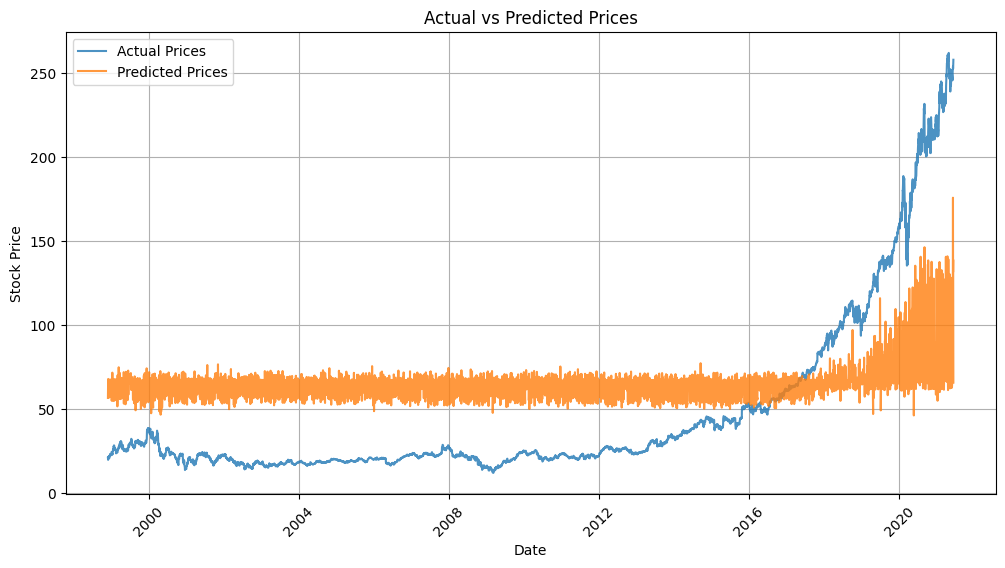

In [70]:
plot_actual_vs_predicted(dates, y_sequence_rescaled, y_pred_rescaled)

In [46]:
simple_lstm_model.save(base_path + 'simple_lstm_model4_3.keras')

In [ ]:
import tensorflow as tf

# Load the model
simple_lstm_model = tf.keras.models.load_model(base_path + 'simple_lstm_model4_2.keras')

# Verify the model summary
simple_lstm_model.summary()


Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ numerical_input           │ (None, 30, 12)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_1 (LSTM)       │ (None, 30, 50)         │         12,600 │ numerical_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 30, 50)         │            200 │ lstm_layer_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_2 (LSTM)       │ (None, 30, 25)         │          7,600 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 30, 25)         │            100 │ lstm_layer_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 30, 25)         │             25 │ batch_normalization_5… │
│ (AdditiveAttention)       │                        │                │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 30, 25)         │              0 │ lstm_layer_2[0][0],    │
│                           │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 750)            │              0 │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │         24,032 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             33 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 133,472 (521.38 KB)

 Trainable params: 44,440 (173.59 KB)

 Non-trainable params: 150 (600.00 B)

 Optimizer params: 88,882 (347.20 KB)

In [ ]:
stock_data = pd.read_csv(stock_prices_path)

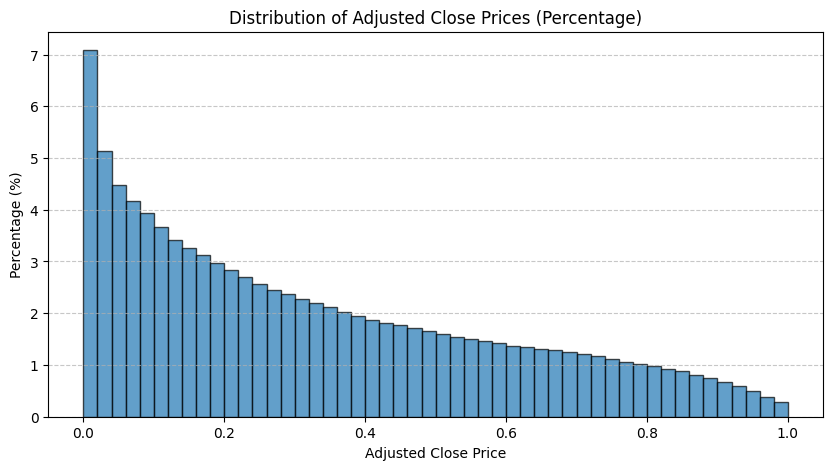

In [ ]:
# Assuming stock_data['close_adjusted'] is a valid column in a DataFrame
# Simulating data if actual data is unavailable

import numpy as np

# Simulated data (if user doesn't upload real data)
# stock_data = pd.DataFrame({'close_adjusted': np.random.lognormal(mean=2, sigma=0.5, size=1000)})

# Plotting the histogram with percentages on the Y-axis
plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(
    stock_data_tidy['close_adjusted'],
    bins=50,
    weights=np.ones_like(stock_data_tidy['close_adjusted']) / len(stock_data_tidy['close_adjusted']) * 100,
    edgecolor='black',
    alpha=0.7
)
plt.xlabel('Adjusted Close Price')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Adjusted Close Prices (Percentage)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import numpy as np

# Move those somewhere, where they can be seen

def preprocess_data(stock_data_tidy, numerical_columns, sequence_length):
    """
    Converts stock_data_tidy into sequences for LSTM training.

    Args:
        stock_data_tidy (pd.DataFrame): The input stock dataset.
        numerical_columns (list): The feature columns.
        sequence_length (int): The number of time steps per sequence.

    Returns:
        X (np.array): Shape (samples, sequence_length, num_features)
        y (np.array): Shape (samples,)
    """
    data = stock_data_tidy[numerical_columns].values

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i])  # Last `sequence_length` rows
        y.append(data[i, 0])  # Target value (Assuming `close_adjusted` is first)

    return np.array(X), np.array(y)


In [ ]:
# Define feature columns
target_column = 'close_adjusted'  # Assuming this is the target

# Ensure target column is first in `numerical_columns`
if target_column in numerical_columns:
    numerical_columns.remove(target_column)
numerical_columns.insert(0, target_column)

# Convert to sequences
X_train, y_train = preprocess_data(train_data, numerical_columns, sequence_length)
X_test, y_test = preprocess_data(test_data, numerical_columns, sequence_length)

# Print shape to verify correctness
print(f"X_train shape: {X_train.shape}")  # Should be (samples, 30, num_features)
print(f"y_train shape: {y_train.shape}")  # Should be (samples,)


In [ ]:
import numpy as np

# Define function to create sequences for LSTM
def create_sequences(data, target_column, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i+time_steps].drop(columns=[target_column]).values)  # Input features excluding target
        y.append(data.iloc[i+time_steps][target_column])  # Target value for close_adjusted
    return np.array(X), np.array(y)

# Assuming 'aapl_data' is your DataFrame with numerical features and 'close_adjusted' as target
X_train, y_train = create_sequences(aapl_data[numerical_columns], target_column='close_adjusted', time_steps=sequence_length)

# Display the shape of the prepared dataset
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (5639, 60, 11)
y_train shape: (5639,)


In [ ]:
numerical_columns

['close_adjusted',
 'RSI',
 '5_day_MA',
 '10_day_MA',
 '20_day_MA',
 '50_day_MA',
 '100_day_MA',
 '200_day_MA',
 'MACD',
 'Signal_Line',
 'day_of_week',
 'ticker_encoded']

In [ ]:
keras.backend.clear_session()

In [47]:
y_pred = simple_lstm_model.predict(X_sequences)

NameError: name 'X_sequences' is not defined

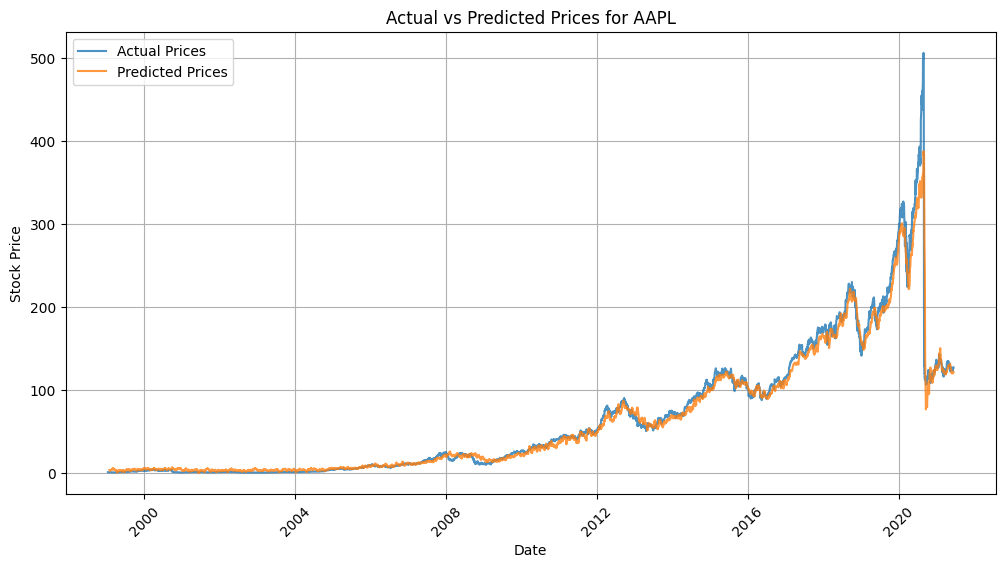

In [ ]:
y_pred_rescaled = inverse_transform_predictions(y_pred, aapl_data.ticker_encoded.unique()[0])

y_sequence_rescaled = inverse_transform_predictions(y_sequences, aapl_data.ticker_encoded.unique()[0])
y_pred_rescaled = inverse_transform_predictions(y_pred, aapl_data.ticker_encoded.unique()[0])

plt.figure(figsize=(12, 6))

# Slice the date column to match the predictions
dates = aapl_data['date'].iloc[sequence_length:].reset_index(drop=True)

y_pred_smoothed = pd.Series(y_pred_rescaled).rolling(window=10).mean()

plt.plot(dates, y_sequence_rescaled, label='Actual Prices', alpha=0.8)
plt.plot(dates, y_pred_smoothed, label='Predicted Prices', alpha=0.8)

plt.title('Actual vs Predicted Prices for AAPL')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [ ]:
simple_lstm_model.fit(
    x_data, y_data,
    epochs=50,
    callbacks=[early_stopping],  # Include checkpoint callback
    verbose=1
)


Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0024 - mae: 0.0379
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.8654e-04 - mae: 0.0244
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0011 - mae: 0.0248
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.8100e-04 - mae: 0.0218
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.2400e-04 - mae: 0.0220
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.1432e-04 - mae: 0.0217
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.3766e-04 - mae: 0.0191
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.0900e-04 - mae: 0.0196
Epoch 9/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.1069e-04 - mae: 0.0182
Epoch 10/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.4843e-04 - mae: 0.0176
Epoch 11/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.9958e-04 - mae: 0.0195
Epoch 12/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss